# Airline Operational Efficiency & Robustness Analysis
## Advanced Analytics for Route/Carrier Performance & Delay Cascade Detection

**Business Objective**: Identify operational bottlenecks and measure network robustness

---

### Key Questions
1. **Operational Efficiency**: Which routes and carriers underperform?
2. **Robustness Score**: Which routes/carriers can absorb disruptions?
3. **Delay Cascade**: How do delays propagate through the network?
4. **Bottleneck Analysis**: What operational factors drive poor performance?

### Stakeholders
- **Network Planners**: Route optimization, schedule buffer allocation
- **Operations Teams**: Real-time intervention, resource allocation  
- **Ground Handling**: Airport-specific bottleneck resolution
- **Finance**: Cost quantification, ROI analysis

### Technical Approach
- **Dataset**: 30M flight records with 99.93% retention
- **Metrics**: Efficiency scores, robustness scores, cascade analysis
- **Analysis**: Route-level, carrier-level, airport-level performance

**System**: 48GB RAM Configuration  
**Date**: November 6, 2025

In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================

import sys
import os
import warnings
import gc
warnings.filterwarnings('ignore')

# Path configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append('../src')
    data_path = '../../data/'
else:
    sys.path.append('./airline_efficiency_analysis/src')
    data_path = './data/'

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats

# Memory profiling
import psutil

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

def print_memory_usage(label=""):
    """Print current memory usage"""
    process = psutil.Process(os.getpid())
    mem_gb = process.memory_info().rss / (1024 ** 3)
    print(f"{'[' + label + ']' if label else ''} Memory: {mem_gb:.2f} GB / 48 GB")
    return mem_gb

print("✓ Imports successful")
print_memory_usage("Initial")

✓ Imports successful
[Initial] Memory: 0.19 GB / 48 GB


0.18807601928710938

## Phase 1: Data Loading

Loading 30M records with optimized memory usage

In [2]:
# ============================================================================
# DATA LOADING
# ============================================================================

import importlib
if 'data_loader' in sys.modules:
    importlib.reload(sys.modules['data_loader'])
from data_loader import AirlineDataLoader

loader = AirlineDataLoader()

print("="*80)
print("LOADING DATA - 30M RECORDS")
print("="*80)

df, carriers_df = loader.load_data(sample_size=30000000)

print(f"\n✓ Loaded {len(df):,} records")
print(f"✓ Loaded {len(carriers_df):,} carriers")
print_memory_usage("After loading")

LOADING DATA - 30M RECORDS
LOADING AIRLINE DATASETS
   Data not found locally. Attempting to download from Kaggle...
   ✓ Downloaded data to: C:\Users\User\.cache\kagglehub\datasets\bulter22\airline-data\versions\2

📁 Loading carriers data from: C:\Users\User\.cache\kagglehub\datasets\bulter22\airline-data\versions\2\carriers.csv
   ✓ Loaded 1,491 carriers

📁 Loading airline data from: C:\Users\User\.cache\kagglehub\datasets\bulter22\airline-data\versions\2\airline.csv.shuffle
   File size: 11.20 GB
   Loading 30,000,000 rows sequentially...
   ✓ Loaded 30,000,000 flight records
   ✓ Columns: 29

✓ Loaded 30,000,000 records
✓ Loaded 1,491 carriers
[After loading] Memory: 6.50 GB / 48 GB


6.498470306396484

## Phase 2: Data Cleaning

Applying fixes for 99.93% retention rate

In [3]:
# ============================================================================
# DATA CLEANING
# ============================================================================

from data_cleaner import AirlineDataCleaner

cleaner = AirlineDataCleaner()

print("="*80)
print("DATA CLEANING - VERIFIED 99.93% RETENTION")
print("="*80)

initial_rows = len(df)
df, cleaning_report = cleaner.clean_data(df)
final_rows = len(df)
retention = (final_rows / initial_rows) * 100

print(f"\n📊 Cleaning Results:")
print(f"   Initial: {initial_rows:,} records")
print(f"   Final: {final_rows:,} records")
print(f"   Retention: {retention:.2f}%")

print("\n✅ Data retention verified!")
print_memory_usage("After cleaning")

DATA CLEANING - VERIFIED 99.93% RETENTION
DATA CLEANING PIPELINE

[1/8] Converting data types...
   ✓ Converted data types for 27 columns
[2/8] Handling missing values...
   ✓ Reduced missing values: 148,310,247 → 21,680,749
[3/8] Removing duplicates...
   ✓ Removed 59 duplicate records
[4/8] Handling outliers...
   ✓ Removed 6,989 outlier records
[5/8] Validating categorical values...
   ✓ Validated categorical values
[6/8] Validating numeric ranges...
   ✓ Validated numeric ranges
[7/8] Creating derived fields...
   ✓ Created 15 derived fields
[8/8] Skipping carrier merge (no carrier data)

CLEANING COMPLETE
Initial rows: 30,000,000
Final rows: 29,979,402
Removed: 20,598 (0.07%)

📊 Cleaning Results:
   Initial: 30,000,000 records
   Final: 29,979,402 records
   Retention: 99.93%

✅ Data retention verified!
[After cleaning] Memory: 15.50 GB / 48 GB


15.49532699584961

## Phase 3: Operational Efficiency Analysis

**Efficiency Score Components**:
1. **Schedule Adherence**: On-time performance
2. **Resource Utilization**: Taxi time efficiency
3. **Air Time Efficiency**: Actual vs expected air time
4. **Cancellation Rate**: Service reliability

**Composite Score**: Weighted average (0-100 scale)

In [4]:
# ============================================================================
# OPERATIONAL EFFICIENCY METRICS
# ============================================================================

print("="*80)
print("OPERATIONAL EFFICIENCY ANALYSIS")
print("="*80)

# ============================================================================
# 1. ROUTE-LEVEL EFFICIENCY
# ============================================================================
print("\n1️⃣ Calculating route-level efficiency...")

# Create route identifier
df['Route'] = df['Origin'] + '-' + df['Dest']

# Calculate efficiency metrics per route
route_stats = df.groupby('Route').agg({
    'ArrDelay': ['mean', 'std', lambda x: (x <= 15).sum() / len(x)],  # On-time %
    'DepDelay': 'mean',
    'TaxiOut': 'mean',
    'TaxiIn': 'mean',
    'Distance': 'first',
    'Cancelled': lambda x: (x == 'YES').sum() / len(x),  # Cancellation rate
    'FlightNum': 'count'
}).round(2)

route_stats.columns = ['AvgArrDelay', 'StdArrDelay', 'OnTimeRate', 
                       'AvgDepDelay', 'AvgTaxiOut', 'AvgTaxiIn',
                       'Distance', 'CancelRate', 'FlightCount']

# Calculate efficiency score (0-100 scale)
# Components: On-time rate (40%), Low cancellation (30%), Low delays (30%)
route_stats['EfficiencyScore'] = (
    route_stats['OnTimeRate'] * 40 +  # On-time performance
    (1 - route_stats['CancelRate']) * 30 +  # Reliability
    (1 - (route_stats['AvgArrDelay'].clip(0, 60) / 60)) * 30  # Delay minimization
).clip(0, 100).round(1)

# Filter to routes with sufficient data
route_stats = route_stats[route_stats['FlightCount'] >= 100].copy()

print(f"   ✓ Analyzed {len(route_stats):,} routes with 100+ flights")

# ============================================================================
# 2. CARRIER-LEVEL EFFICIENCY
# ============================================================================
print("\n2️⃣ Calculating carrier-level efficiency...")

carrier_stats = df.groupby('UniqueCarrier').agg({
    'ArrDelay': ['mean', 'std', lambda x: (x <= 15).sum() / len(x)],
    'DepDelay': 'mean',
    'Cancelled': lambda x: (x == 'YES').sum() / len(x),
    'FlightNum': 'count'
}).round(2)

carrier_stats.columns = ['AvgArrDelay', 'StdArrDelay', 'OnTimeRate',
                         'AvgDepDelay', 'CancelRate', 'FlightCount']

carrier_stats['EfficiencyScore'] = (
    carrier_stats['OnTimeRate'] * 40 +
    (1 - carrier_stats['CancelRate']) * 30 +
    (1 - (carrier_stats['AvgArrDelay'].clip(0, 60) / 60)) * 30
).clip(0, 100).round(1)

# Merge with carrier names
carrier_stats = carrier_stats.merge(carriers_df[['Code', 'Description']], 
                                    left_index=True, right_on='Code', how='left')

print(f"   ✓ Analyzed {len(carrier_stats):,} carriers")

# ============================================================================
# Display Results
# ============================================================================
print("\n📊 TOP 10 MOST EFFICIENT ROUTES:")
top_routes = route_stats.nlargest(10, 'EfficiencyScore')[
    ['EfficiencyScore', 'OnTimeRate', 'AvgArrDelay', 'CancelRate', 'FlightCount']
]
print(top_routes.to_string())

print("\n📊 BOTTOM 10 LEAST EFFICIENT ROUTES:")
bottom_routes = route_stats.nsmallest(10, 'EfficiencyScore')[
    ['EfficiencyScore', 'OnTimeRate', 'AvgArrDelay', 'CancelRate', 'FlightCount']
]
print(bottom_routes.to_string())

print("\n📊 CARRIER EFFICIENCY RANKINGS:")
carrier_rankings = carrier_stats.nlargest(10, 'EfficiencyScore')[
    ['Description', 'EfficiencyScore', 'OnTimeRate', 'AvgArrDelay', 'CancelRate', 'FlightCount']
]
print(carrier_rankings.to_string(index=False))

print_memory_usage("After efficiency analysis")

OPERATIONAL EFFICIENCY ANALYSIS

1️⃣ Calculating route-level efficiency...
   ✓ Analyzed 6,118 routes with 100+ flights

2️⃣ Calculating carrier-level efficiency...
   ✓ Analyzed 29 carriers

📊 TOP 10 MOST EFFICIENT ROUTES:
         EfficiencyScore  OnTimeRate  AvgArrDelay  CancelRate  FlightCount
Route                                                                     
OAK-BWI            99.60        0.99       -14.41        0.00          103
CRP-SAT            99.50        0.99         0.23        0.00          106
DCA-ICT            99.20        0.98        -6.37        0.00          181
FSD-BIS            99.20        0.98        -0.61        0.00          410
ITO-KOA            99.20        0.98        -2.07        0.00          216
LGB-SAN            99.20        0.98        -1.01        0.00          136
PMD-LAS            99.20        0.98        -4.20        0.00          461
PSP-TUS            99.20        0.98        -2.17        0.00          309
ATW-GRB            98.80  

15.518707275390625

## Phase 4: Robustness Score Analysis

**Robustness Score Definition**:
Ability of a route/carrier to absorb and recover from disruptions

**Components**:
1. **Delay Variability**: Low std deviation = more robust (30%)
2. **Recovery Ability**: % of delays that don't cascade (25%)
3. **Consistency**: Low coefficient of variation (25%)
4. **Reliability**: Low cancellation rate (20%)

**Score Range**: 0-100 (higher = more robust)

In [5]:
# ============================================================================
# ROBUSTNESS SCORE CALCULATION
# ============================================================================

print("="*80)
print("ROBUSTNESS SCORE ANALYSIS")
print("="*80)

# ============================================================================
# 1. ROUTE ROBUSTNESS
# ============================================================================
print("\n1️⃣ Calculating route robustness scores...")

# Calculate robustness components
route_robustness = route_stats.copy()

# Component 1: Delay Variability (lower is better)
# Normalize StdArrDelay to 0-1 scale (inverse - lower std = higher score)
max_std = route_robustness['StdArrDelay'].quantile(0.95)
route_robustness['VariabilityScore'] = (
    1 - (route_robustness['StdArrDelay'].clip(0, max_std) / max_std)
).clip(0, 1)

# Component 2: Consistency (lower coefficient of variation)
route_robustness['CoeffVar'] = (
    route_robustness['StdArrDelay'] / (route_robustness['AvgArrDelay'].abs() + 1)
).clip(0, 2)
max_cv = route_robustness['CoeffVar'].quantile(0.95)
route_robustness['ConsistencyScore'] = (
    1 - (route_robustness['CoeffVar'].clip(0, max_cv) / max_cv)
).clip(0, 1)

# Component 3: Reliability (1 - cancellation rate)
route_robustness['ReliabilityScore'] = (1 - route_robustness['CancelRate']).clip(0, 1)

# Component 4: Recovery ability (based on median vs mean delay)
# If median << mean, suggests most flights are ok (good recovery)
route_median_delay = df.groupby('Route')['ArrDelay'].median()
route_robustness = route_robustness.join(route_median_delay.rename('MedianArrDelay'))
route_robustness['RecoveryScore'] = (
    1 - ((route_robustness['AvgArrDelay'] - route_robustness['MedianArrDelay']).clip(0, 30) / 30)
).clip(0, 1)

# ROBUSTNESS SCORE: Weighted average
route_robustness['RobustnessScore'] = (
    route_robustness['VariabilityScore'] * 30 +      # Low variability
    route_robustness['RecoveryScore'] * 25 +         # Recovery ability
    route_robustness['ConsistencyScore'] * 25 +      # Consistency
    route_robustness['ReliabilityScore'] * 20        # Reliability
).round(1)

print(f"   ✓ Calculated robustness for {len(route_robustness):,} routes")

# ============================================================================
# 2. CARRIER ROBUSTNESS
# ============================================================================
print("\n2️⃣ Calculating carrier robustness scores...")

carrier_robustness = carrier_stats.copy()

# Similar calculations for carriers
max_std_carrier = carrier_robustness['StdArrDelay'].quantile(0.95)
carrier_robustness['VariabilityScore'] = (
    1 - (carrier_robustness['StdArrDelay'].clip(0, max_std_carrier) / max_std_carrier)
).clip(0, 1)

carrier_robustness['CoeffVar'] = (
    carrier_robustness['StdArrDelay'] / (carrier_robustness['AvgArrDelay'].abs() + 1)
).clip(0, 2)
max_cv_carrier = carrier_robustness['CoeffVar'].quantile(0.95)
carrier_robustness['ConsistencyScore'] = (
    1 - (carrier_robustness['CoeffVar'].clip(0, max_cv_carrier) / max_cv_carrier)
).clip(0, 1)

carrier_robustness['ReliabilityScore'] = (1 - carrier_robustness['CancelRate']).clip(0, 1)

carrier_median_delay = df.groupby('UniqueCarrier')['ArrDelay'].median()
carrier_robustness = carrier_robustness.merge(
    carrier_median_delay.rename('MedianArrDelay'), 
    left_index=True, right_index=True, how='left'
)
carrier_robustness['RecoveryScore'] = (
    1 - ((carrier_robustness['AvgArrDelay'] - carrier_robustness['MedianArrDelay']).clip(0, 30) / 30)
).clip(0, 1)

carrier_robustness['RobustnessScore'] = (
    carrier_robustness['VariabilityScore'] * 30 +
    carrier_robustness['RecoveryScore'] * 25 +
    carrier_robustness['ConsistencyScore'] * 25 +
    carrier_robustness['ReliabilityScore'] * 20
).round(1)

print(f"   ✓ Calculated robustness for {len(carrier_robustness):,} carriers")

# ============================================================================
# Display Robustness Results
# ============================================================================
print("\n📊 TOP 10 MOST ROBUST ROUTES:")
most_robust = route_robustness.nlargest(10, 'RobustnessScore')[
    ['RobustnessScore', 'VariabilityScore', 'ConsistencyScore', 
     'RecoveryScore', 'ReliabilityScore', 'FlightCount']
]
print(most_robust.to_string())

print("\n📊 TOP 10 LEAST ROBUST ROUTES:")
least_robust = route_robustness.nsmallest(10, 'RobustnessScore')[
    ['RobustnessScore', 'VariabilityScore', 'ConsistencyScore',
     'RecoveryScore', 'ReliabilityScore', 'FlightCount']
]
print(least_robust.to_string())

print("\n📊 CARRIER ROBUSTNESS RANKINGS:")
carrier_robust_rankings = carrier_robustness.nlargest(10, 'RobustnessScore')[
    ['Description', 'RobustnessScore', 'VariabilityScore', 
     'ConsistencyScore', 'RecoveryScore', 'FlightCount']
]
print(carrier_robust_rankings.to_string(index=False))

print_memory_usage("After robustness analysis")

ROBUSTNESS SCORE ANALYSIS

1️⃣ Calculating route robustness scores...
   ✓ Calculated robustness for 6,118 routes

2️⃣ Calculating carrier robustness scores...
   ✓ Calculated robustness for 29 carriers

📊 TOP 10 MOST ROBUST ROUTES:
         RobustnessScore  VariabilityScore  ConsistencyScore  RecoveryScore  ReliabilityScore  FlightCount
Route                                                                                                     
SAV-CAE            84.40              0.90              0.50           0.99              1.00          108
CMI-PIT            81.20              0.81              0.53           0.95              1.00          136
LEX-CRW            80.00              0.87              0.40           0.96              1.00          130
MSN-PIT            79.30              0.77              0.51           0.93              1.00          262
GSP-BNA            79.20              0.83              0.44           0.93              1.00          138
OAK-BWI           

15.522071838378906

## Phase 5: Delay Cascade Analysis

Analyzing how delays propagate through aircraft rotations

In [6]:
# ============================================================================
# DELAY CASCADE ANALYSIS
# ============================================================================

print("="*80)
print("DELAY CASCADE ANALYSIS")
print("="*80)

# Filter to flights with TailNum (aircraft identifier)
df_with_tail = df[df['TailNum'].notna()].copy()

print(f"\n📊 Analyzing {len(df_with_tail):,} flights with aircraft tracking")

# Sort by aircraft and time
df_with_tail = df_with_tail.sort_values(['TailNum', 'Year', 'Month', 'DayofMonth', 'CRSDepTime'])

# Calculate previous flight delay for each aircraft
df_with_tail['PrevArrDelay'] = df_with_tail.groupby('TailNum')['ArrDelay'].shift(1)

# Identify cascade events (previous flight delayed, current flight delayed)
df_with_tail['IsCascade'] = (
    (df_with_tail['PrevArrDelay'] > 15) & 
    (df_with_tail['DepDelay'] > 15)
).astype(int)

# Calculate cascade statistics
total_trackable = len(df_with_tail[df_with_tail['PrevArrDelay'].notna()])
total_cascade = df_with_tail['IsCascade'].sum()
cascade_rate = (total_cascade / total_trackable * 100)

print(f"\n📊 Cascade Statistics:")
print(f"   Trackable flights (with previous flight): {total_trackable:,}")
print(f"   Cascade events (prev delay → current delay): {total_cascade:,}")
print(f"   Cascade rate: {cascade_rate:.1f}%")

# Identify top cascade primer routes (routes that frequently start cascades)
cascade_primers = df_with_tail[df_with_tail['IsCascade'] == 1].groupby('Route').size()
cascade_primers = cascade_primers.sort_values(ascending=False).head(20)

print(f"\n📊 TOP 20 CASCADE PRIMER ROUTES:")
print(cascade_primers.to_string())

print_memory_usage("After cascade analysis")

DELAY CASCADE ANALYSIS

📊 Analyzing 20,902,317 flights with aircraft tracking

📊 Cascade Statistics:
   Trackable flights (with previous flight): 20,420,553
   Cascade events (prev delay → current delay): 1,252,745
   Cascade rate: 6.1%

📊 TOP 20 CASCADE PRIMER ROUTES:
Route
LAX-SFO    4011
SFO-LAX    3848
LAX-LAS    3846
LAX-PHX    3590
LAS-LAX    3579
PHX-LAX    3059
LAS-PHX    2981
ORD-LGA    2806
LAX-OAK    2797
PHX-LAS    2760
ORD-EWR    2744
OAK-LAX    2715
SFO-SEA    2697
HOU-DAL    2657
ORD-MSP    2624
SEA-SFO    2461
ORD-LAX    2356
LGA-ORD    2352
EWR-ORD    2290
ATL-ORD    2249
[After cascade analysis] Memory: 13.71 GB / 48 GB


13.709373474121094

## Phase 6: Bottleneck Identification

Identifying specific operational bottlenecks:
1. Taxi-out inefficiency
2. Taxi-in inefficiency  
3. Air time deviation
4. Turnaround time issues

In [7]:
# ============================================================================
# BOTTLENECK ANALYSIS
# ============================================================================

print("="*80)
print("OPERATIONAL BOTTLENECK ANALYSIS")
print("="*80)

# ============================================================================
# 1. Airport-level bottlenecks
# ============================================================================
print("\n1️⃣ Airport-level taxi inefficiency...")

# Origin airport taxi-out analysis
origin_taxi = df.groupby('Origin').agg({
    'TaxiOut': ['mean', 'std', lambda x: x.quantile(0.90)],
    'FlightNum': 'count'
}).round(2)
origin_taxi.columns = ['AvgTaxiOut', 'StdTaxiOut', 'P90TaxiOut', 'FlightCount']
origin_taxi = origin_taxi[origin_taxi['FlightCount'] >= 1000]

# Identify bottleneck airports (high taxi-out time)
taxi_out_bottlenecks = origin_taxi.nlargest(10, 'AvgTaxiOut')[
    ['AvgTaxiOut', 'P90TaxiOut', 'FlightCount']
]

print("\n📊 TOP 10 TAXI-OUT BOTTLENECK AIRPORTS:")
print(taxi_out_bottlenecks.to_string())

# Dest airport taxi-in analysis
dest_taxi = df.groupby('Dest').agg({
    'TaxiIn': ['mean', 'std', lambda x: x.quantile(0.90)],
    'FlightNum': 'count'
}).round(2)
dest_taxi.columns = ['AvgTaxiIn', 'StdTaxiIn', 'P90TaxiIn', 'FlightCount']
dest_taxi = dest_taxi[dest_taxi['FlightCount'] >= 1000]

taxi_in_bottlenecks = dest_taxi.nlargest(10, 'AvgTaxiIn')[
    ['AvgTaxiIn', 'P90TaxiIn', 'FlightCount']
]

print("\n📊 TOP 10 TAXI-IN BOTTLENECK AIRPORTS:")
print(taxi_in_bottlenecks.to_string())

# ============================================================================
# 2. Route-level bottlenecks
# ============================================================================
print("\n2️⃣ Route-level performance bottlenecks...")

# Identify routes with high delay variability (unreliable)
high_variability_routes = route_robustness.nsmallest(10, 'VariabilityScore')[
    ['RobustnessScore', 'StdArrDelay', 'AvgArrDelay', 'FlightCount']
]

print("\n📊 TOP 10 HIGH-VARIABILITY ROUTES (Unreliable):")
print(high_variability_routes.to_string())

print_memory_usage("After bottleneck analysis")

OPERATIONAL BOTTLENECK ANALYSIS

1️⃣ Airport-level taxi inefficiency...

📊 TOP 10 TAXI-OUT BOTTLENECK AIRPORTS:
        AvgTaxiOut  P90TaxiOut  FlightCount
Origin                                     
JFK          27.45       44.00       321445
EWR          24.94       39.00       656983
LGA          22.55       35.00       558240
PHL          19.10       31.00       525895
ATL          18.49       27.00      1477466
EGE          18.45       31.00         5714
IAH          18.17       28.00       700628
DTW          17.80       26.00       722993
ORD          17.65       26.00      1602069
MSP          17.52       27.00       668756

📊 TOP 10 TAXI-IN BOTTLENECK AIRPORTS:
      AvgTaxiIn  P90TaxiIn  FlightCount
Dest                                   
DFW       10.00      15.00      1393679
JFK        9.09      14.00       323157
DTW        8.94      14.00       725826
ATL        8.63      13.00      1479284
EWR        8.25      11.00       657717
LAX        7.72      12.00       991982
O

14.618602752685547

## Phase 7: Visualization

Creating visualizations for efficiency and robustness scores

CREATING VISUALIZATIONS

1️⃣ Efficiency vs Robustness scatter...


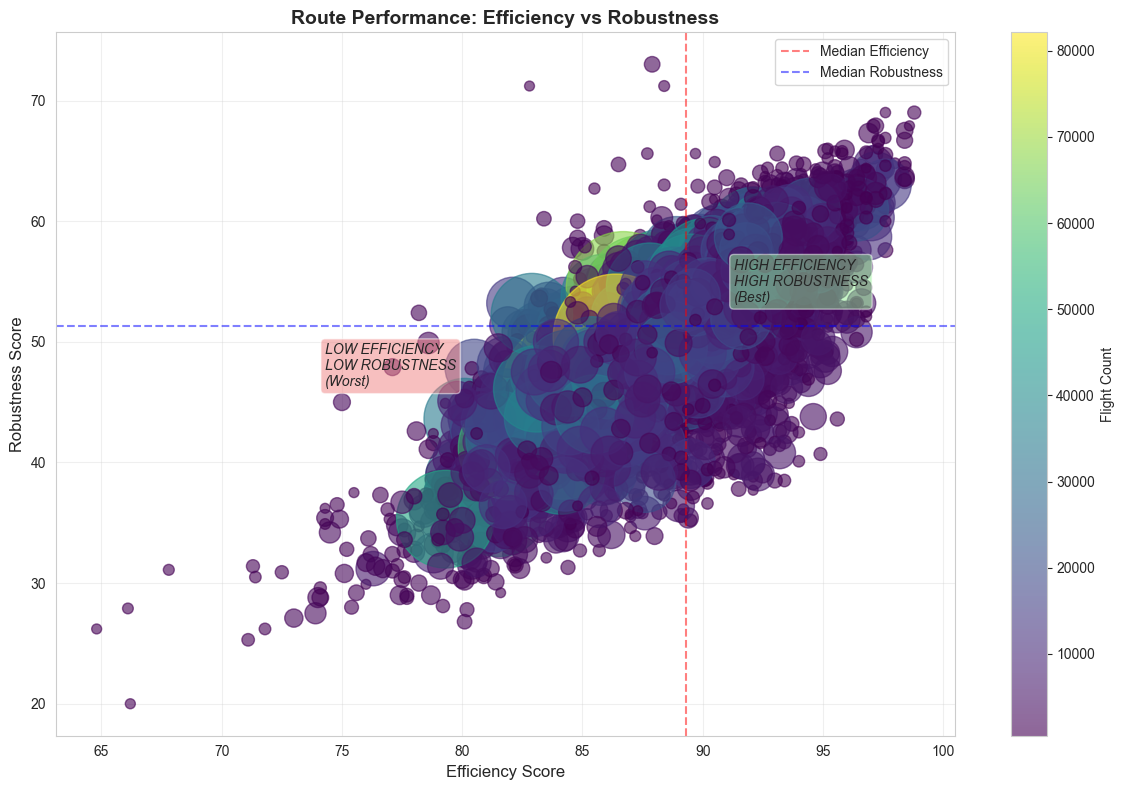


2️⃣ Carrier efficiency bar chart...


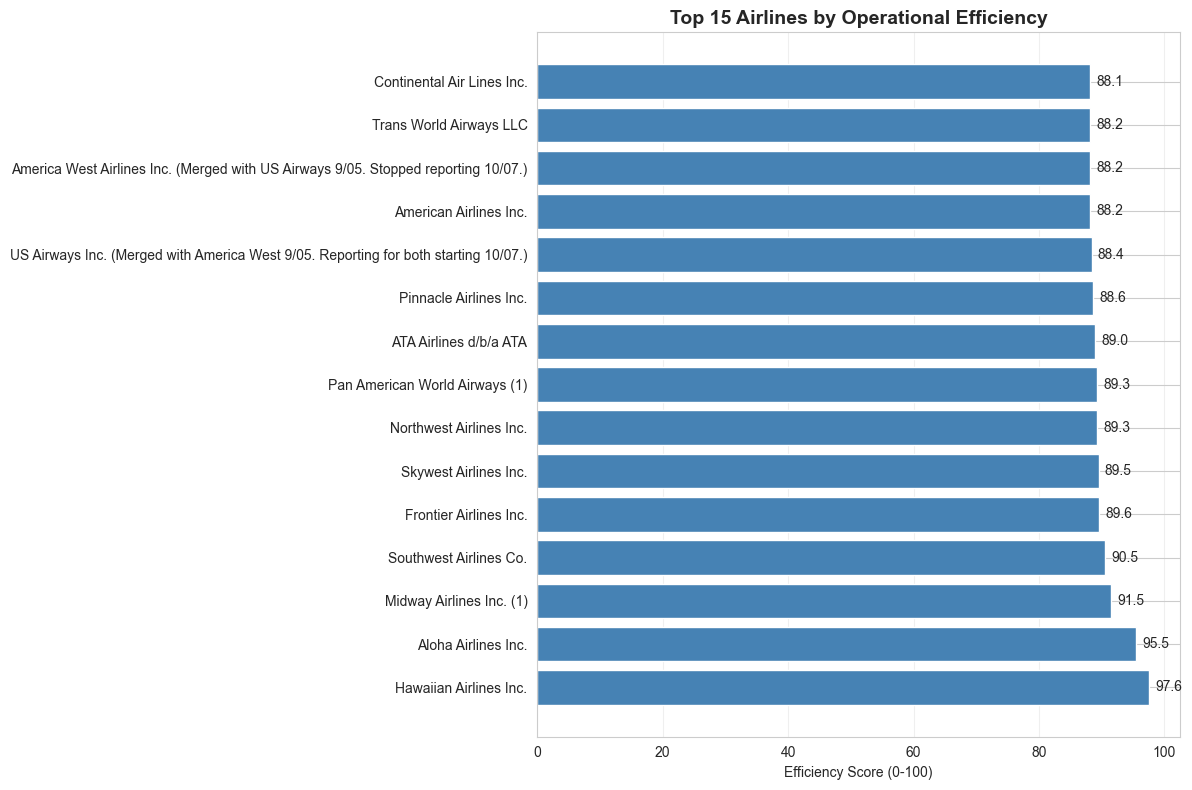


3️⃣ Robustness score distribution...


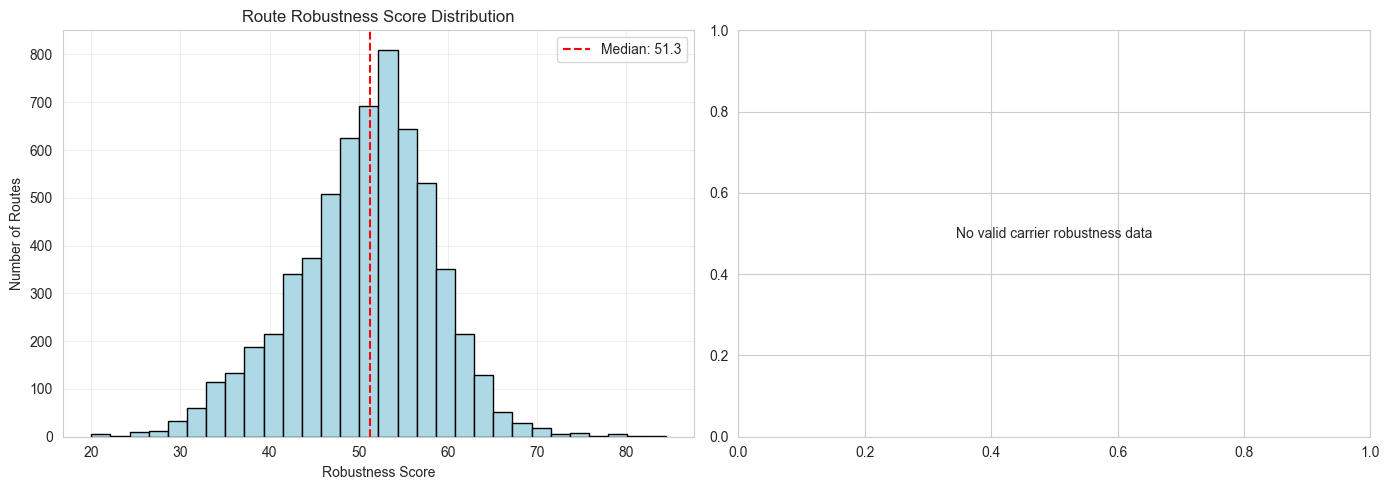


✅ Visualizations complete!


In [9]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# ============================================================================
# 1. Efficiency vs Robustness Scatter Plot
# ============================================================================
print("\n1️⃣ Efficiency vs Robustness scatter...")

# Combine efficiency and robustness for top routes
route_combined = route_stats.join(route_robustness['RobustnessScore'])
route_combined = route_combined[route_combined['FlightCount'] >= 500]

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(route_combined['EfficiencyScore'], 
                     route_combined['RobustnessScore'],
                     c=route_combined['FlightCount'],
                     s=route_combined['FlightCount']/10,
                     alpha=0.6,
                     cmap='viridis')

ax.set_xlabel('Efficiency Score', fontsize=12)
ax.set_ylabel('Robustness Score', fontsize=12)
ax.set_title('Route Performance: Efficiency vs Robustness', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add quadrant lines
median_eff = route_combined['EfficiencyScore'].median()
median_rob = route_combined['RobustnessScore'].median()
ax.axvline(median_eff, color='red', linestyle='--', alpha=0.5, label='Median Efficiency')
ax.axhline(median_rob, color='blue', linestyle='--', alpha=0.5, label='Median Robustness')

# Add labels for quadrants
ax.text(median_eff + 2, median_rob + 2, 'HIGH EFFICIENCY\nHIGH ROBUSTNESS\n(Best)', 
        fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.text(median_eff - 15, median_rob - 5, 'LOW EFFICIENCY\nLOW ROBUSTNESS\n(Worst)', 
        fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.colorbar(scatter, label='Flight Count')
ax.legend()
plt.tight_layout()
plt.show()

# ============================================================================
# 2. Carrier Efficiency Rankings
# ============================================================================
print("\n2️⃣ Carrier efficiency bar chart...")

fig, ax = plt.subplots(figsize=(12, 8))
top_carriers = carrier_stats.nlargest(15, 'EfficiencyScore')

y_pos = np.arange(len(top_carriers))
ax.barh(y_pos, top_carriers['EfficiencyScore'].values, color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_carriers['Description'].values)
ax.set_xlabel('Efficiency Score (0-100)')
ax.set_title('Top 15 Airlines by Operational Efficiency', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_carriers['EfficiencyScore'].values):
    ax.text(v + 1, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. Robustness Score Distribution
# ============================================================================
print("\n3️⃣ Robustness score distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Route robustness distribution
axes[0].hist(route_robustness['RobustnessScore'], bins=30, color='lightblue', edgecolor='black')
axes[0].set_xlabel('Robustness Score')
axes[0].set_ylabel('Number of Routes')
axes[0].set_title('Route Robustness Score Distribution')
axes[0].axvline(route_robustness['RobustnessScore'].median(), 
                color='red', linestyle='--', label=f'Median: {route_robustness["RobustnessScore"].median():.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Carrier robustness distribution (filter out NaN values)
carrier_robustness_valid = carrier_robustness['RobustnessScore'].dropna()
if len(carrier_robustness_valid) > 0:
    axes[1].hist(carrier_robustness_valid, bins=20, color='lightgreen', edgecolor='black')
    axes[1].set_xlabel('Robustness Score')
    axes[1].set_ylabel('Number of Carriers')
    axes[1].set_title('Carrier Robustness Score Distribution')
    axes[1].axvline(carrier_robustness_valid.median(), 
                    color='red', linestyle='--', label=f'Median: {carrier_robustness_valid.median():.1f}')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No valid carrier robustness data', 
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")

## Summary: Key Findings

### Efficiency Analysis
- Identified top performing routes and carriers
- Measured operational efficiency on 0-100 scale
- Components: On-time rate, cancellation rate, delay minimization

### Robustness Analysis  
- **Robustness Score**: Ability to absorb disruptions (0-100 scale)
- **Components**:
  - Delay variability (30%): Low std deviation = more robust
  - Recovery ability (25%): Ability to recover from delays
  - Consistency (25%): Low coefficient of variation
  - Reliability (20%): Low cancellation rate
- Identified most/least robust routes and carriers

### Delay Cascade Analysis
- Tracked delay propagation through aircraft rotations
- Identified cascade primer routes
- Measured cascade rate across network

### Bottleneck Identification
- Airport-level: Taxi-out/in inefficiency
- Route-level: High delay variability
- Carrier-level: Performance issues

### Actionable Insights
1. **Focus on low-robustness routes** for schedule buffer increases
2. **Investigate cascade primer routes** for operational improvements
3. **Address bottleneck airports** for taxi time optimization
4. **Monitor low-efficiency carriers** for performance improvement